Import all needed libraries

In [1]:
import re
import nltk
import ir_datasets
import numpy as np
import math
import matplotlib.pyplot as plt

Tokenizing function:

This function gets a list of texts and tokenize each text

In [2]:
def tokenize(list_of_contexts):
    all_tokens = []         # a list to save all of tokens of all documents
    for i, doc in enumerate(list_of_contexts):
        lower_doc = doc.lower()              # make all of contexts lower case
        list_of_contexts[i] = lower_doc          
        tokens = re.findall(r'\d+(?:,\d+)*(?:\.\d+)?|\w+', list_of_contexts[i])   # tokenize the text with regex
        all_tokens.append(tokens)

    return all_tokens       # return a 2D array with contains lists of tokens of each document

Filtering tokens:

This function is for preprocessing tokens like removing stopwords and stemming

In [3]:
def token_filtering(all_tokens):
    for i, doc in enumerate(all_tokens):
        new_tokens = []
        for token in doc:     # delete all of stopwords and single character tokens except numbers from token list
            if (len(token) < 2 and token.isalpha()) or (token in stop_words):          
                continue
            else:
                new_tokens.append(token)
        stemmer = nltk.stem.PorterStemmer()                      # stemming each token
        new_tokens = [stemmer.stem(token) for token in new_tokens]
        all_tokens[i] = new_tokens

    return all_tokens

# Download the stopwords
nltk.download('stopwords')
nltk.download('punkt')
# Get the list of stopwords for English
stop_words = set(nltk.corpus.stopwords.words('english'))

    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Create a mapping list for terms to termIDs. each unique term is maped to a unique integer

In [4]:
def build_term_id(all_tokens):
    termID = []
    for doc in all_tokens:               # create a list of all unique terms in collection
        for term in doc:
            if term not in termID:    # if the term is not already in the list
                termID.append(term)

    return termID

Create a 2D array(term-document matrix) that entry i and j is the TF of term i in document j

In [5]:
def calculate_TF(tf, option, max_tf_d, max_tf_t):
    if option==1:   # binary model {0, 1}
        if tf>0:    
            return 1
        return 0
    elif option==2:    # n: TF_t,d
        return tf
    elif option==3:    # l: 1+log(TF)
        if tf>0:
            return 1 + math.log2(tf)
        return 0.1
    elif option==4:     # m: ntf
        return 0.4 + 0.6*((tf)/(max_tf_d))
    else:               # a
        return 0.5 + 0.5*((tf)/(max_tf_t))

In [6]:
def build_term_document_matrix(all_tokens, termID, option):
    term_doc = np.zeros((len(termID), len(all_tokens)))  # an empy matrix rows=len(terms) and columns=len(collection)
    # build term-doc matrix
    for i, doc in enumerate(all_tokens):
        for term in doc:
            try:   # if term is happened in the termID map
                term_ind = termID.index(term)     # row
                doc_ind = i                       # column
                term_doc[term_ind][doc_ind] += 1  # increase the frequency of the term in the document
            except:
                continue
    
    max_tf_row = []
    max_tf_col = []
    for i in range(len(term_doc)):             # find TF_max in each document and TF_max for each term
        max_tf_row.append(max(term_doc[i]))
    for j in range(len(term_doc[0])):
        col = []
        for i in range(len(term_doc)):
            col.append(term_doc[i][j])
        max_tf_col.append(max(col))

    for i in range(len(term_doc)):            # update term-doc weights based on given option
        for j in range(len(term_doc[i])):
            max_tf_t = max_tf_row[i]
            max_tf_d = max_tf_col[j]
            tf = term_doc[i][j]
            term_doc[i][j] = calculate_TF(tf, option, max_tf_d, max_tf_t)
        
    return term_doc


create an IDF list that stores document frequency of each term

In [7]:
# calculate idf based on given algorithm
def calculate_IDF(N, DF_t, option):
    if option == 1:  # n
        return 1
    elif option==2:   # t
        return math.log2(N/DF_t)
    else:   # p
        return max(0, math.log2((N - DF_t)/(DF_t)))
    

In [8]:
def build_idf(all_tokens, term_ID, option):
    idf = np.zeros(len(term_ID))

    for i, term in enumerate(term_ID):
        count = 0
        for doc in all_tokens:     # if term happened in document i, increase doc frequency of it
            if term in doc:
                count += 1

        idf_t = calculate_IDF(len(all_tokens), count, option)   # calculate idf_t and put it in list of idfs
        idf[i] = idf_t

    return idf

Vector-Space Model

In [9]:
# calculate w(t, d) = tf * idf / norm

def calculate_smart_weighting(weight_matrix):
    norm_d = []    # calculate c in each doc
    for j in range(weight_matrix.shape[1]):
        weights_in_doc = []
        for i in range(weight_matrix.shape[0]):
            weights_in_doc.append(weight_matrix[i][j])
        
        sum_e = 0
        for w in weights_in_doc:
            sum_e += w**2
        c = 1/(math.sqrt(sum_e))
        norm_d.append(c)

    for i in range(weight_matrix.shape[0]):
        for j in range(weight_matrix.shape[1]):
            weight_matrix[i][j] /= norm_d[j]

    return weight_matrix

In [10]:
def build_weight_matrix(term_doc_matrix, idf, option):
    m = term_doc_matrix.shape[0]
    n = term_doc_matrix.shape[1]
    weight_matrix = np.zeros((m, n)) 
    for i in range(m):      # calculating weight of each term in each document using w(t, d) = tf * idf
        for j in range(n):
            weight_matrix[i][j] = term_doc_matrix[i][j] * idf[i]
    
    if option==2:   # choose to calculate smart weight 
        weight_matrix = calculate_smart_weighting(weight_matrix)
            
    return weight_matrix

In [36]:
def vector_space_model(query_vector, weight_matrix):
    
    number_of_docs = weight_matrix.shape[1]       
    number_of_terms = weight_matrix.shape[0]

    norm_q = 0
    for i in range(number_of_terms):
        norm_q += query_vector[i][0]**2
    norm_q = math.sqrt(norm_q)

    doc_scores = []
    for j in range(number_of_docs):        # calculate similarity of query vector with each document
        score_doc_j = 0
        norm_d = 0
        for i in range(number_of_terms):
            norm_d += weight_matrix[i][j]**2
        norm_d = math.sqrt(norm_d)
        for i in range(number_of_terms):
            score_doc_j += (weight_matrix[i][j]/norm_d) * (query_vector[i][0]/norm_q)    # score(d, q) = v(d).v(q)
        doc_scores.append((score_doc_j, j+1))   # save score of each document, j+1 is the doc_id of j'th document
    
    return doc_scores


Probabilistic Model(Okapi BM25)

In [12]:
def probabilistic_model(query_tokens, query_vector, idf, term_doc_matrix, all_tokens, term_ID, k1, k3, b):
    L_ave = 0
    document_length = []           # find length of all documents in collection
    for doc in all_tokens:
        document_length.append(len(doc))
        L_ave += len(doc)
    L_ave /= len(all_tokens)         # average doc length in whole collection

    query_length = len(query_tokens)
    number_of_docs = term_doc_matrix.shape[1]
    number_of_terms = term_doc_matrix.shape[0]
    doc_RSVs = []
    for j in range(number_of_docs):
        RSV_j = 0
        for i in range(number_of_terms):
            if term_ID[i] in query_tokens:      # for each query term, calculate similar weighting
                tf_td = term_doc_matrix[i][j]
                tf_tq = query_vector[i][0]     # frequecny of term i in query 
                Ld = document_length[j]
                if query_length > 30:       # for long queries
                    RSV_j += idf[i] * ( ((k1+1)*tf_td) / (k1*((1-b) + b*(Ld/L_ave)) + tf_td)) * (((k3+1)*tf_tq) / (k3+tf_tq))
                else:
                    RSV_j += idf[i] * ( ((k1+1)*tf_td) / (k1*((1-b) + b*(Ld/L_ave)) + tf_td))
        
        doc_RSVs.append((RSV_j, j+1))        # add the score of each document to score list

    return doc_RSVs


Language Model

different smoothing functions

In [13]:
def jelinek_mercer_smoothing(landa, term_freq_in_doc_j, Ld, term_freq_in_collection, Lc):
    return ((landa * (term_freq_in_doc_j/Ld)) + ((1-landa) * (term_freq_in_collection/Lc)))

In [14]:
def dirichlet_smoothing(term_freq_in_doc_j, term_freq_in_collection, Lc, Ld, alpha):
    return (term_freq_in_doc_j + (alpha * (term_freq_in_collection/Lc))) / (Ld + alpha)

In [15]:
def language_model(query_tokens, term_ID, term_doc_matrix, all_tokens, landa, alpha, smoothing_option):
    Lc = 0
    document_length = []
    for doc in all_tokens:
        document_length.append(len(doc))
        Lc += len(doc)                        # total number of terms in collection

    number_of_docs = term_doc_matrix.shape[1]
    number_of_terms = term_doc_matrix.shape[0]
    doc_scores = []
    for j in range(number_of_docs):
        score_j = 1
        for i in range(number_of_terms):
            if term_ID[i] in query_tokens:        # for each query term calculate probability
                term_freq_in_doc_j = term_doc_matrix[i][j]
                Ld = document_length[j]
                term_freq_in_collection = 0
                for l in range(len(term_doc_matrix[i])):
                    term_freq_in_collection += term_doc_matrix[i][l]
                if smoothing_option == 1:
                    score_j *= jelinek_mercer_smoothing(landa, term_freq_in_doc_j, Ld, term_freq_in_collection, Lc)
                else:
                    score_j *= dirichlet_smoothing(term_freq_in_doc_j, term_freq_in_collection, Lc, Ld, alpha)

        doc_scores.append((score_j, j+1))

    return doc_scores

Heap sort for document ranking

In [16]:
def heap_sort(scores, k):
    sorted_scores = scores[:k]
    scores = scores[k:]
    while scores:
        sorted_scores = sorted(sorted_scores, reverse=True)
        if scores[0][0] > sorted_scores[k-1][0]: # if first element of scores is greather than min element of heap, replce it 
            sorted_scores[k-1] = scores[0]
        scores.pop(0)

    return sorted_scores

Rank the documents based on scores

In [26]:
def score_function(scores, k):
    sorted_scores = heap_sort(scores, k)
    retrieved_docs = []
    for s in sorted_scores:
        if s[0] > 0:
            retrieved_docs.append(s)
   
    return retrieved_docs

11-point evaluation

In [21]:
def evaluation_11_points(retrieved, relevats):

    number_of_all_relevant_docs = len(relevats)
    precisions = []        # save the precision of i'th doc
    recalls = []           # save the recall of i'th doc
    number_of_docs_seen = 1    # docs that we have seen so far
    number_of_relevents_seen = 0      # number of relevant docs that we have seen so far
    for doc in retrieved:
        if doc in relevats:
            number_of_relevents_seen += 1
        precision = number_of_relevents_seen / number_of_docs_seen
        recall    = number_of_relevents_seen / number_of_all_relevant_docs
        precisions.append(precision)
        recalls.append(recall)
        number_of_docs_seen += 1

    points_11 = np.zeros(11) 
    x_points = np.zeros(11)
    recall = 0.0
    avg = 0
    for j in range(11):                        # find precision at 11 points of recall
        for i, r in enumerate(recalls):
            if r >= recall:
                pr = max(precisions[i:])
                points_11[j] = pr
                break

        avg += pr
        x_points[j] = recall
        recall += 0.1
        recall = np.round(recall, 1)
    avg /= 11                            # compute average precision

    return avg, points_11, x_points




Main code

In [18]:
def preproccessing(dataset, filtering_option=1):
    # Load the cranfield dataset
    

    list_of_contexts = []      # all of file's contexts
    # Iterate over the documents in the dataset and read them and put them in a list
    for doc in dataset.docs_iter():
        doc_title = doc.title
        text = doc.text
        list_of_contexts.append(doc_title+" "+text)

    all_tokens = tokenize(list_of_contexts)          # list of all tokens in the dataset
    if filtering_option:   # give a choice to user that want to remove stopwords and stemming or not
        all_tokens = token_filtering(all_tokens)         # filtering, removing stopwords, and stemming tokens

    return all_tokens

In [19]:
def data_proccessing(all_tokens, tf_option=2, idf_option=2):
    # build a list that maps each unique term to a unique integer that is an identifier for that term
    term_ID = build_term_id(all_tokens)
    # build term-document matrix
    term_doc_matrix = build_term_document_matrix(all_tokens, term_ID, tf_option)
    idf = build_idf(all_tokens, term_ID, idf_option)

    return term_ID, term_doc_matrix, idf

In [41]:
def test(model, query, k, term_ID, term_doc_matrix, idf, all_tokens, weight_matrix=[], tf_option=2, filtering_option=1, k1=1.2, k3=1.2, b=0.75, landa=0.5, alpha=0.5, smoothing_option=1):
    # consider query as a document and proccess it like documents
    query_context = [query]
    query_tokens = tokenize(query_context)
    if filtering_option:
        query_tokens = token_filtering(query_tokens)

    query_vector = build_term_document_matrix(query_tokens, term_ID, tf_option)

    if model==1:       # vector-space model
        doc_scores = vector_space_model(query_vector, weight_matrix)
    elif model==2:     # probabilistic model
        doc_scores = probabilistic_model(query_tokens[0], query_vector, idf, term_doc_matrix, all_tokens, term_ID, k1, k3, b)
    elif model==3:
        doc_scores = language_model(query_tokens[0], term_ID, term_doc_matrix, all_tokens, landa, alpha, smoothing_option)

    retrieved = score_function(doc_scores, k)
    retrieved_ids = [s[1] for s in retrieved]
    return retrieved, retrieved_ids


In [22]:
def eval_pr_re(retrieved, relevants):
    count = 0
    for r in retrieved:
        if r in relevants:
            count += 1
    return count / len(relevants)

In [30]:
def MAP(retrieved, relevants):
    count = 0
    for r in retrieved:
        if r in relevants:
            count += 1
    
    return count/len(retrieved)

Running main

In [47]:
dataset = ir_datasets.load("cranfield")
all_tokens = preproccessing(dataset, filtering_option=0)
term_ID, term_doc_matrix, idf = data_proccessing(all_tokens, tf_option=2, idf_option=3)
weight_matrix = build_weight_matrix(term_doc_matrix, idf, 1)

get and preproccess queries and query relevancies

In [48]:
def query_proccessing(dataset):
    queries = dataset.queries_iter()
    all_queries = []
    for q in queries:
        all_queries.append((q.query_id, q.text))     # save all queries and query ids in a list

    all_qrels = dataset.qrels_iter()
    qrels = []
    for q in all_qrels:
        qrels.append(q)                # save all relevancies of queries in a list
    all_relevancies = {}            # create a dictionary which key is the query id and its value is it's relevant documents 
    qrel_id = qrels[0].query_id
    all_relevancies[qrel_id]=[]
    for qrel in qrels:
        if qrel.relevance > 0:     # add document id of relevant documents to value of document id in the dictionary
            if qrel.query_id == qrel_id:
                all_relevancies[qrel_id].append(int(qrel.doc_id))
            else:
                qrel_id = qrel.query_id
                all_relevancies[qrel_id]= [int(qrel.doc_id)]

    return all_queries, all_relevancies


Test each model with some given queries and evaluate using 11-point

C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3314775356.py:19: RuntimeWarning: invalid value encountered in double_scalars
  score_doc_j += (weight_matrix[i][j]/norm_d) * (query_vector[i][0]/norm_q)    # score(d, q) = v(d).v(q)
C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3923962413.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((landa * (term_freq_in_doc_j/Ld)) + ((1-landa) * (term_freq_in_collection/Lc)))


red: vector-space model
green: probabilistic model
blue: language model


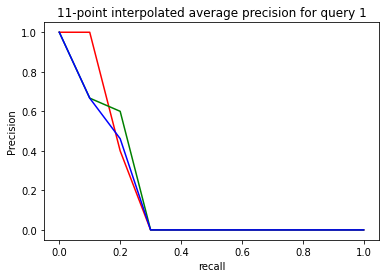

C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3314775356.py:19: RuntimeWarning: invalid value encountered in double_scalars
  score_doc_j += (weight_matrix[i][j]/norm_d) * (query_vector[i][0]/norm_q)    # score(d, q) = v(d).v(q)
C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3923962413.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((landa * (term_freq_in_doc_j/Ld)) + ((1-landa) * (term_freq_in_collection/Lc)))


red: vector-space model
green: probabilistic model
blue: language model


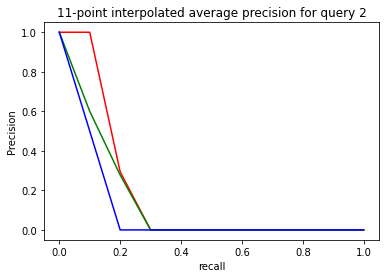

In [49]:
all_queries, all_relevancies = query_proccessing(dataset)
query1 = all_queries[0]
k = 20         # number of top k documents that should be retrieved
retrieved1, retrieved1_ids = test(model=1, query=query1[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix,
            idf=idf, all_tokens=all_tokens, weight_matrix=weight_matrix, tf_option=2, filtering_option=0)
avg1, y1, x1 = evaluation_11_points(retrieved1_ids, all_relevancies[query1[0]])
plt.plot(x1, y1, 'r')
retrieved2, retrieved2_ids = test(model=2, query=query1[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens,
                tf_option=2, filtering_option=0, k1=1.2, k3=1.2, b=0.75)
avg2, y2, x2 =evaluation_11_points(retrieved2_ids, all_relevancies[query1[0]])
plt.plot(x2, y2, 'g')
retrieved3, retrieved3_ids = test(model=3, query=query1[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens, 
                tf_option=2, filtering_option=0, landa=0.5, alpha=0.1, smoothing_option=1)
avg3, y3, x3 =evaluation_11_points(retrieved3_ids, all_relevancies[query1[0]])
plt.plot(x3, y3, 'b')
print("red: vector-space model")
print("green: probabilistic model")
print("blue: language model")
plt.title("11-point interpolated average precision for query 1")
plt.xlabel("recall")
plt.ylabel("Precision")
plt.show()
################################################################
query2 = all_queries[1]
k = 20         # number of top k documents that should be retrieved
retrieved1, retrieved1_ids = test(model=1, query=query2[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens,
                weight_matrix=weight_matrix, tf_option=2, filtering_option=0)
avg1, y1, x1 = evaluation_11_points(retrieved1_ids, all_relevancies[query2[0]])
plt.plot(x1, y1, 'r')
retrieved2, retrieved2_ids = test(model=2, query=query2[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens,
                tf_option=2, filtering_option=0, k1=1.2, k3=1.2, b=0.75)
avg2, y2, x2 =evaluation_11_points(retrieved2_ids, all_relevancies[query2[0]])
plt.plot(x2, y2, 'g')
retrieved3, retrieved3_ids = test(model=3, query=query2[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens, 
                tf_option=2, filtering_option=0, landa=0.5, alpha=0.1, smoothing_option=1)
avg3, y3, x3 =evaluation_11_points(retrieved3_ids, all_relevancies[query2[0]])
plt.plot(x3, y3, 'b')
print("red: vector-space model")
print("green: probabilistic model")
print("blue: language model")
plt.title("11-point interpolated average precision for query 2")
plt.xlabel("recall")
plt.ylabel("Precision")
plt.show()


Evaluate each model: a different approach

C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3314775356.py:19: RuntimeWarning: invalid value encountered in double_scalars
  score_doc_j += (weight_matrix[i][j]/norm_d) * (query_vector[i][0]/norm_q)    # score(d, q) = v(d).v(q)
C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3923962413.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((landa * (term_freq_in_doc_j/Ld)) + ((1-landa) * (term_freq_in_collection/Lc)))


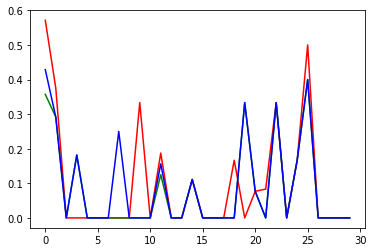

In [50]:
all_queries, all_relevancies = query_proccessing(dataset)
xpoints = np.zeros(30)
ypoints1 = np.zeros(30)
ypoints2 = np.zeros(30)
ypoints3 = np.zeros(30)
for i, qq in enumerate(all_queries[:30]):
    xpoints[i] = i
    k = 100         # number of top k documents that should be retrieved

    retrieved1, retrieved1_ids = test(model=1, query=qq[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens,
                    weight_matrix=weight_matrix,tf_option=2, filtering_option=0)
    pr1 = eval_pr_re(retrieved1_ids, all_relevancies[qq[0]])
    ypoints1[i] = pr1

    retrieved2, retrieved2_ids = test(model=2, query=qq[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens,
                    tf_option=2, filtering_option=0, k1=1.2, k3=1.2, b=0.75)
    pr2 = eval_pr_re(retrieved2_ids, all_relevancies[qq[0]])
    ypoints2[i] = pr2

    retrieved3, retrieved3_ids = test(model=3, query=qq[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens, 
                    tf_option=2, filtering_option=0, landa=0.5, alpha=0.1, smoothing_option=1)
    pr3 = eval_pr_re(retrieved3_ids, all_relevancies[qq[0]])
    ypoints3[i] = pr3

plt.plot(xpoints, ypoints1, 'r')
plt.plot(xpoints, ypoints2, 'g')
plt.plot(xpoints, ypoints3, 'b')
plt.show()


Expected output

In [58]:
query1 = all_queries[0]
k = 10         # number of top k documents that should be retrieved
retrieved1, retrieved1_ids = test(model=1, query=query1[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix,
            idf=idf, all_tokens=all_tokens, weight_matrix=weight_matrix, tf_option=2, filtering_option=0)

retrieved2, retrieved2_ids = test(model=2, query=query1[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens,
                tf_option=2, filtering_option=0, k1=1.2, k3=1.2, b=0.75)

retrieved3, retrieved3_ids = test(model=3, query=query1[1], k=k, term_ID=term_ID, term_doc_matrix=term_doc_matrix, idf=idf, all_tokens=all_tokens, 
                tf_option=2, filtering_option=0, landa=0.5, alpha=0.1, smoothing_option=1)

print("retrieved documents (vector-space): ")
for d in retrieved1:
    print(f"(ID: {d[1]}, Score: {np.round(d[0], 4)})", end=" ")
print()
print("retrieved documents (BM25): ")
for d in retrieved2:
    print(f"(ID: {d[1]}, Score: {np.round(d[0], 4)})", end=" ")
print()
print("retrieved documents (LM): ")
for d in retrieved3:
    print(f"(ID: {d[1]}, Score: {np.round(d[0]*10**42, 4)})", end=" ")

C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3314775356.py:19: RuntimeWarning: invalid value encountered in double_scalars
  score_doc_j += (weight_matrix[i][j]/norm_d) * (query_vector[i][0]/norm_q)    # score(d, q) = v(d).v(q)
C:\Users\ASC\AppData\Local\Temp\ipykernel_17876\3923962413.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((landa * (term_freq_in_doc_j/Ld)) + ((1-landa) * (term_freq_in_collection/Lc)))


retrieved documents (vector-space): 
(ID: 13, Score: 0.2463) (ID: 184, Score: 0.234) (ID: 12, Score: 0.1989) (ID: 51, Score: 0.172) (ID: 875, Score: 0.1639) (ID: 746, Score: 0.1413) (ID: 792, Score: 0.1412) (ID: 1268, Score: 0.1404) (ID: 435, Score: 0.1395) (ID: 327, Score: 0.1357) 
retrieved documents (BM25): 
(ID: 184, Score: 32.9163) (ID: 486, Score: 30.5892) (ID: 13, Score: 29.1745) (ID: 1268, Score: 25.045) (ID: 12, Score: 24.9756) (ID: 51, Score: 21.1622) (ID: 878, Score: 19.0696) (ID: 875, Score: 18.8628) (ID: 746, Score: 17.8241) (ID: 14, Score: 17.5957) 
retrieved documents (LM): 
(ID: 184, Score: 1.3931) (ID: 486, Score: 0.2207) (ID: 1268, Score: 0.1348) (ID: 13, Score: 0.1008) (ID: 12, Score: 0.0242) (ID: 51, Score: 0.0073) (ID: 878, Score: 0.0008) (ID: 14, Score: 0.0008) (ID: 792, Score: 0.0006) (ID: 1361, Score: 0.0005) 